In [1]:
#Video source: https://www.youtube.com/watch?v=L5litdBc8P4
import cv2
import numpy as np
from PIL import Image
import io
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

def compress_frame(frame, quality=85):
    """Compress an image frame using JPEG compression."""
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality)
    return buffer.getvalue()

def extract_and_compress_video_to_parquet(video_path, parquet_path, compression_quality=85):
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    frames_data = []

    # Frame index
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Compress the frame
        compressed_frame = compress_frame(frame, quality=compression_quality)
        
        # Append frame index and compressed frame to list
        frames_data.append((frame_idx, compressed_frame))
        
        # Increment frame index
        frame_idx += 1

        if frame_idx % (60 * 60) == 0:
            print("Minutes captured assuming 30 fps:", frame_idx / (60 * 30))


    # Release the video capture
    cap.release()

    #print(len(frames_data))

    # Create DataFrame
    df = pd.DataFrame(frames_data, columns=['index', 'compressed_frame'])

    # Save to parquet
    df.to_parquet(parquet_path, engine='pyarrow', compression='snappy')

# Path to the input video and the output parquet file
video_path = "MinecraftLetsPlayVideo.mp4"
parquet_path = "MinecraftLetsPlay_frames.parquet"

# Extract, compress, and save frames to a parquet file
if recaptureVideo := False:
    extract_and_compress_video_to_parquet(video_path, parquet_path)


In [2]:
parquet_path = "MinecraftLetsPlay_frames.parquet"

frameDF = pd.read_parquet(parquet_path)

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms.v2 import Resize
import einx


class FrameDataset(Dataset):
    def __init__(self, frameDF):
        self.frameDF = frameDF
    def __len__(self):
        return self.frameDF.shape[0]
    def __getitem__(self, idx):
        row = self.frameDF.iloc[idx] 
        compressed_frame = row['compressed_frame']
        img = Image.open(io.BytesIO(compressed_frame))
        frame = np.array(img)
        frame = torch.tensor(frame)
        frame = einx.rearrange("h w c -> c h w", frame)
        resizer = Resize((176, 320))
        frame = resizer(frame)
        frame = einx.rearrange("c (h h16) (w w16) -> (h w) (h16 w16 c)", frame, h16=16, w16=16)
        return frame.float() / 255
        
parquet_path = "MinecraftLetsPlay_frames.parquet"

frameDataset = FrameDataset(frameDF)
frameLoader = DataLoader(frameDataset, batch_size=16, shuffle=True)

In [4]:
import matplotlib.pyplot as plt

frameDataset[800].shape

torch.Size([220, 768])

In [5]:
from models.Autoencoder import MaskedAutoencoder
inpDimension = 768
embDim = 16
encoderNumHeads = 1
encoderNumBlocks = 1
decoderNumHeads = 1
decoderNumBlocks = 1
maskingRatio = 0.75

model = MaskedAutoencoder(inpDimension, embDim, encoderNumHeads, encoderNumBlocks, decoderNumHeads, decoderNumBlocks, maskingRatio).cuda()

sampleBatch = next(iter(frameLoader))
maskedInputTensor, maskedDecodedOutput,unscrambledStitchedInpViz, unscrambledStitchedImageBatch = model(sampleBatch.cuda())

In [6]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

trainIdxs, testIdxs = train_test_split(range(len(frameDataset)), train_size = 0.9)
trainSubset = Subset(frameDataset, trainIdxs)
print(len(trainSubset))
trainLoader = DataLoader(trainSubset, batch_size=64, shuffle=True)
testSubset = Subset(frameDataset, testIdxs)
testLoader = DataLoader(testSubset, batch_size=64, shuffle=False)

63867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7199268..2.4001927].


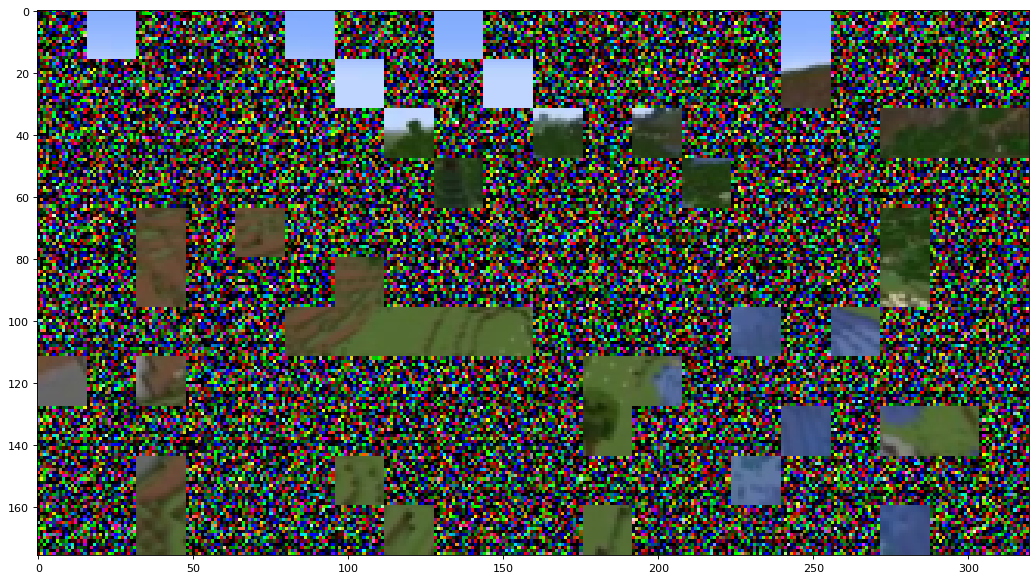

In [7]:
from matplotlib.pyplot import figure


def getPlottableImage(chunkedUpImage):
    frame = einx.rearrange("(h w) (h16 w16 c) -> (h h16) (w w16) c", chunkedUpImage, h16=16, w16=16, h=176 // 16)
    return frame

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inpDimension = 768
embDim = 512
encoderNumHeads = 8
encoderNumBlocks = 8
decoderNumHeads = 8
decoderNumBlocks = 1
maskingRatio = 0.80
model = MaskedAutoencoder(inpDimension, embDim, encoderNumHeads, encoderNumBlocks, decoderNumHeads, decoderNumBlocks, maskingRatio).to(device)


maskedInputTensor, maskedDecodedOutput,unscrambledStitchedInpViz, unscrambledStitchedImageBatch = model(next(iter(trainLoader)).cuda())

figure(figsize=(16, 12), dpi=80)
plt.imshow(getPlottableImage(unscrambledStitchedImageBatch[0]).cpu().detach().numpy())

In [ ]:
optimizer = AdamW(model.parameters(), lr = learningRate)
scheduler = CosineAnnealingLR(optimizer, epochs)

In [62]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


epochs = 100
learningRate = 3e-5


criterion = nn.MSELoss()


epoch = 6
for epoch in range(epochs):
    running_loss = 0
    for idx, frameBatch in enumerate(tqdm(trainLoader)):
        model.zero_grad()
        frameBatch = frameBatch.to(device)
        maskedInputTensor, maskedDecodedOutput, _, unscrambledImageBatch = model(frameBatch)

        loss = criterion(maskedDecodedOutput, maskedInputTensor)
        running_loss += loss.item() * frameBatch.shape[0]

        if epoch == 0:
            loss /= len(trainLoader)
            loss *= (idx + 1)
        
        loss.backward()
        optimizer.step()
        

    running_test_loss = 0
    for idx, frameBatch in enumerate(tqdm(testLoader)):
        with torch.no_grad():
            frameBatch = frameBatch.to(device)
            maskedInputTensor, maskedDecodedOutput, _, unscrambledImageBatch = model(frameBatch)
    
            loss = criterion(maskedDecodedOutput, maskedInputTensor)
            
            running_test_loss += loss.item() * frameBatch.shape[0]

    print(f"Epoch {epoch + 1} / {epochs:<5}: Train Loss: {round(running_loss / len(trainSubset), 3):<8} Test Loss: {round(running_test_loss / len(testSubset), 3):<8}")

    scheduler.step()


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:22<00:00,  4.90it/s]


Epoch 1 / 100  : Train Loss: 0.011    Test Loss: 0.011   


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:23<00:00,  4.73it/s]


Epoch 2 / 100  : Train Loss: 0.011    Test Loss: 0.011   


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:23<00:00,  4.81it/s]


Epoch 3 / 100  : Train Loss: 0.01     Test Loss: 0.01    


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:23<00:00,  4.74it/s]


Epoch 4 / 100  : Train Loss: 0.01     Test Loss: 0.01    


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:23<00:00,  4.72it/s]


Epoch 5 / 100  : Train Loss: 0.01     Test Loss: 0.009   


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:23<00:00,  4.76it/s]


Epoch 6 / 100  : Train Loss: 0.009    Test Loss: 0.009   


 50%|███████████████████████████████████████▋                                        | 495/998 [02:06<02:08,  3.93it/s]


KeyboardInterrupt: 

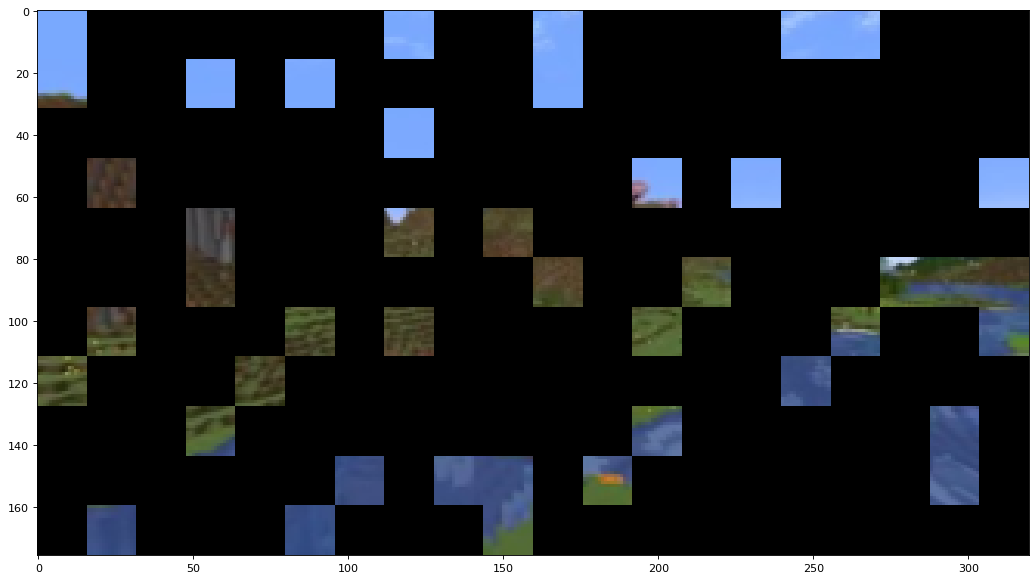

In [124]:
import random

randIdx = random.choice(range(len(trainSubset)))
sampleBatch = trainSubset[randIdx].unsqueeze(0)

sampleBatch = sampleBatch.to(device)
maskedInputTensor, maskedDecodedOutput, inputToDecoderBatch, unscrambledImageBatch = model(sampleBatch)
idx = 0
plottableFrame = getPlottableImage(inputToDecoderBatch[idx])

figure(figsize=(16, 12), dpi=80)

plt.imshow(plottableFrame.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..1.0402613].


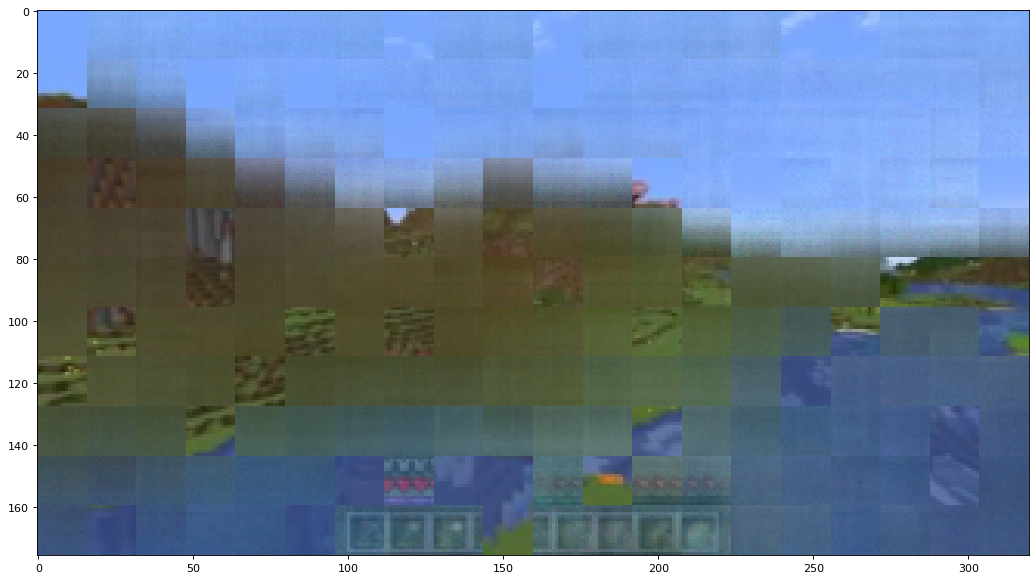

In [125]:
plottableFrame = getPlottableImage(unscrambledImageBatch[idx])

figure(figsize=(16, 12), dpi=80)

plt.imshow(plottableFrame.cpu().detach().numpy())